In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_curve
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
borrower = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/12.loan_grant_data/borrower_table.csv')
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [3]:
borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

In [4]:
loan = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/12.loan_grant_data/loan_table.csv', parse_dates=['date'])
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   loan_id       101100 non-null  int64         
 1   loan_purpose  101100 non-null  object        
 2   date          101100 non-null  datetime64[ns]
 3   loan_granted  101100 non-null  int64         
 4   loan_repaid   47654 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB


### Data Processing

In [6]:
# merge loan and borrower information
data = pd.merge(left=loan, right=borrower, on='loan_id')

In [7]:
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


### EDA

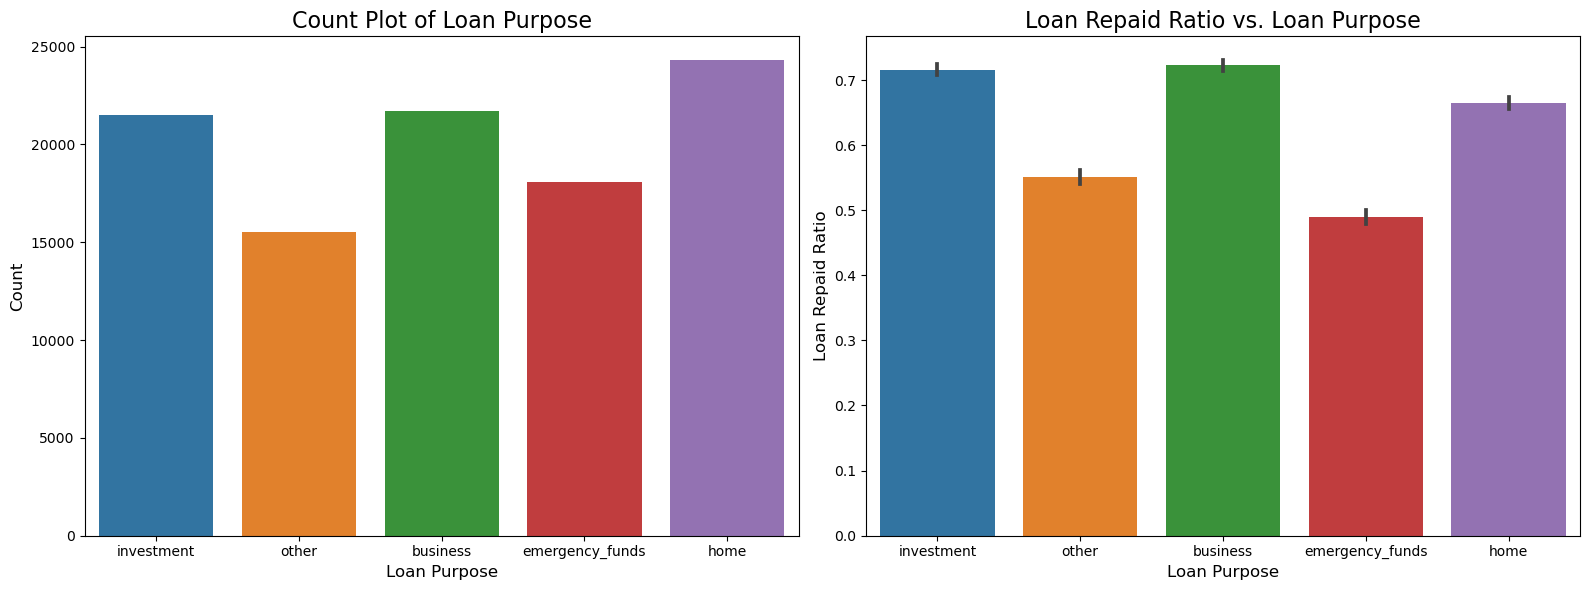

In [8]:
# visualization of 'loan_purpose'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='loan_purpose', data=data, ax=ax[0])
ax[0].set_xlabel('Loan Purpose', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Loan Purpose', fontsize=16)

sns.barplot(x='loan_purpose', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('Loan Purpose', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. Loan Purpose', fontsize=16)
plt.tight_layout()
plt.show()

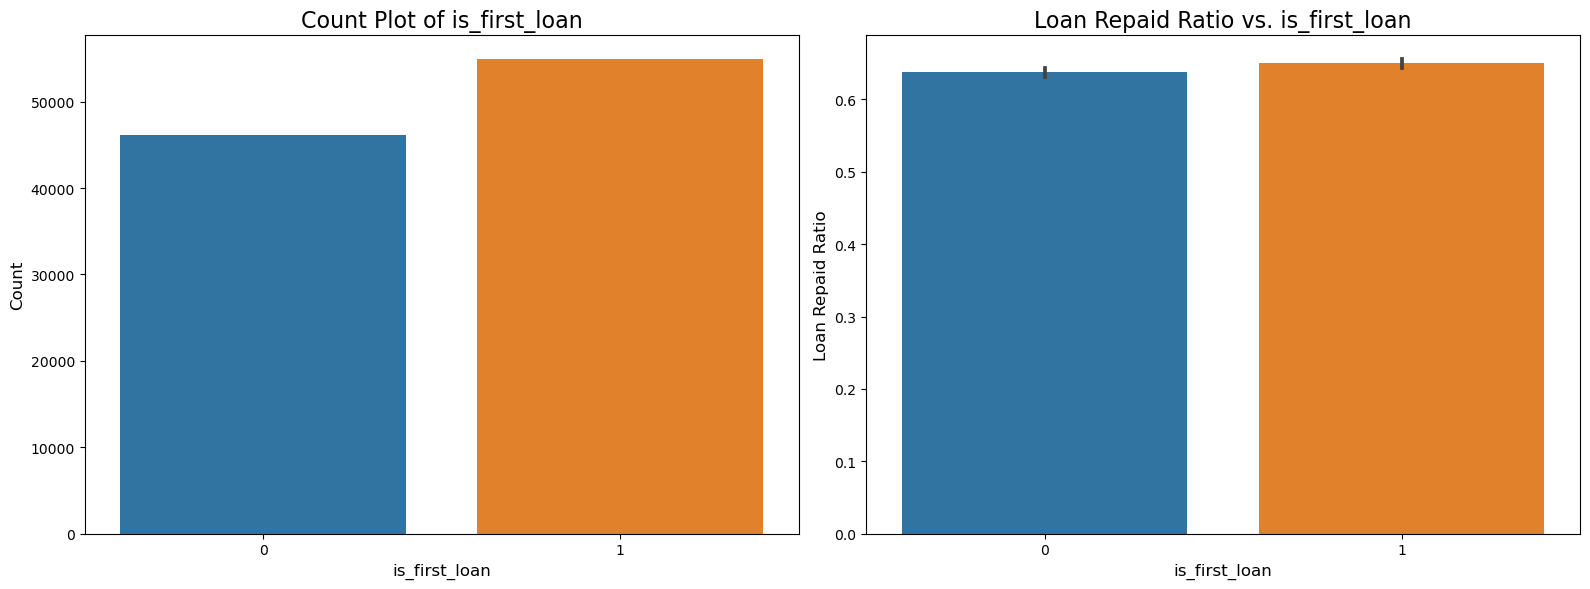

In [9]:
# visualization of 'is_first_loan'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_first_loan', data=data, ax=ax[0])
ax[0].set_xlabel('is_first_loan', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_first_loan', fontsize=16)

sns.barplot(x='is_first_loan', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('is_first_loan', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_first_loan', fontsize=16)
plt.tight_layout()
plt.show()

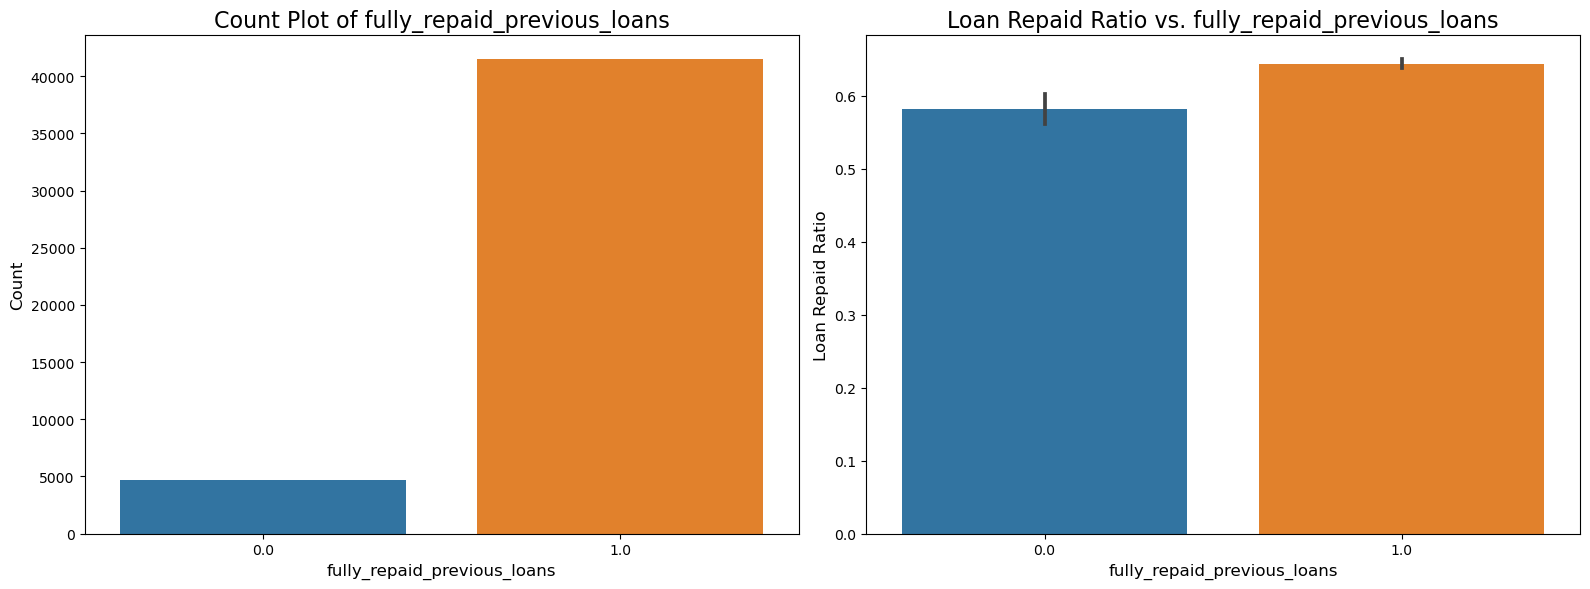

In [10]:
# visualization of 'fully_repaid_previous_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='fully_repaid_previous_loans', data=data, ax=ax[0])
ax[0].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of fully_repaid_previous_loans', fontsize=16)

sns.barplot(x='fully_repaid_previous_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. fully_repaid_previous_loans', fontsize=16)
plt.tight_layout()
plt.show()

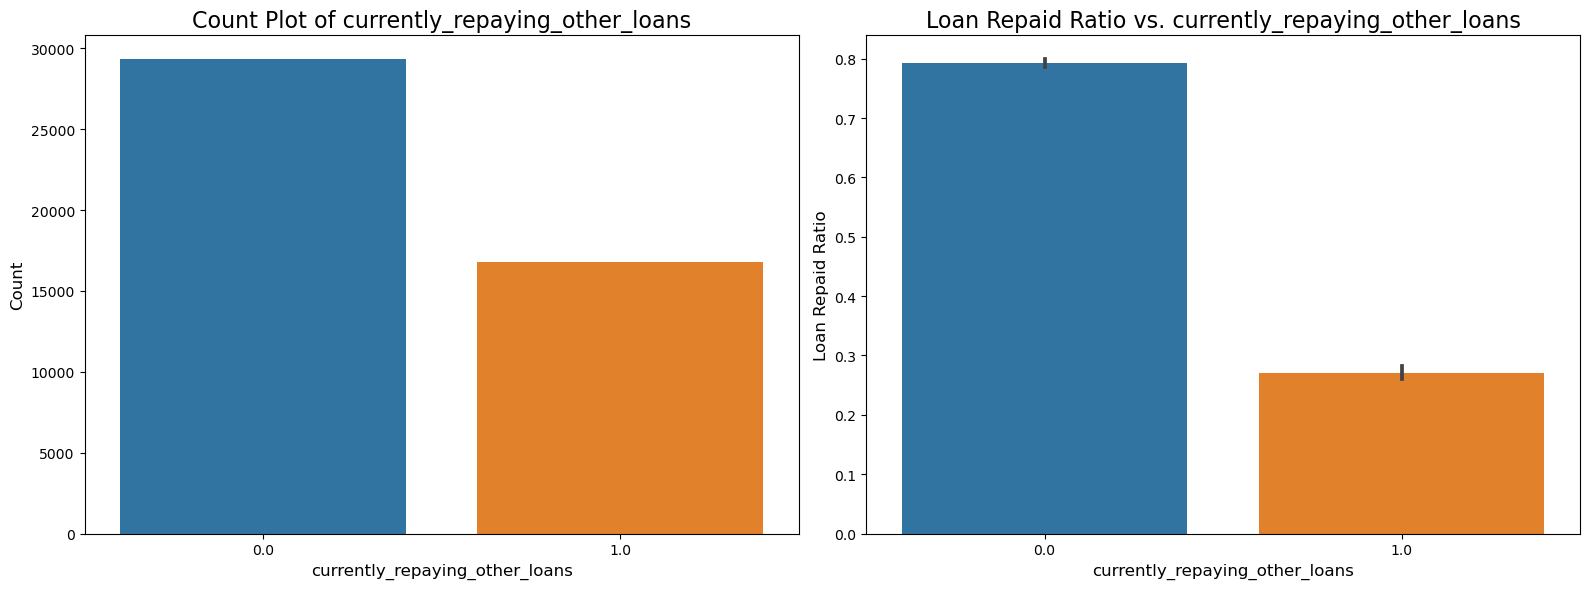

In [11]:
# visualization of 'currently_repaying_other_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='currently_repaying_other_loans', data=data, ax=ax[0])
ax[0].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of currently_repaying_other_loans', fontsize=16)

sns.barplot(x='currently_repaying_other_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. currently_repaying_other_loans', fontsize=16)
plt.tight_layout()
plt.show()

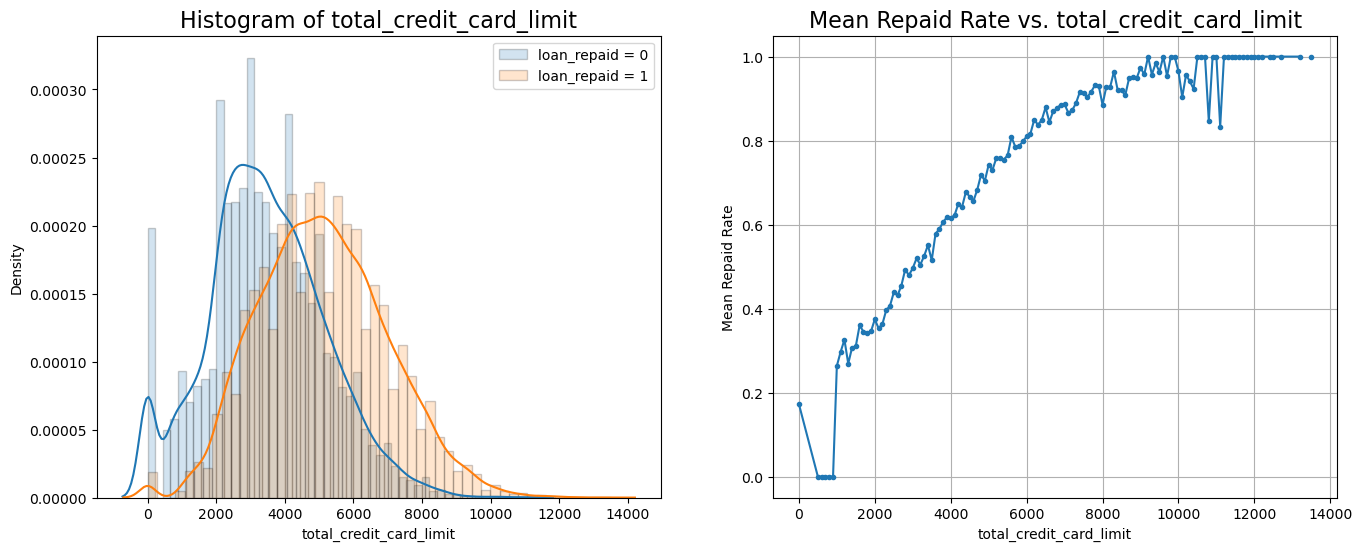

In [12]:
# Visualization of 'total_credit_card_limit'
grouped = data[['total_credit_card_limit', 'loan_repaid']].groupby('total_credit_card_limit')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['total_credit_card_limit'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['total_credit_card_limit'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of total_credit_card_limit', fontsize=16)
ax[0].legend()
ax[1].plot(mean['total_credit_card_limit'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. total_credit_card_limit', fontsize=16)
ax[1].set_xlabel('total_credit_card_limit')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

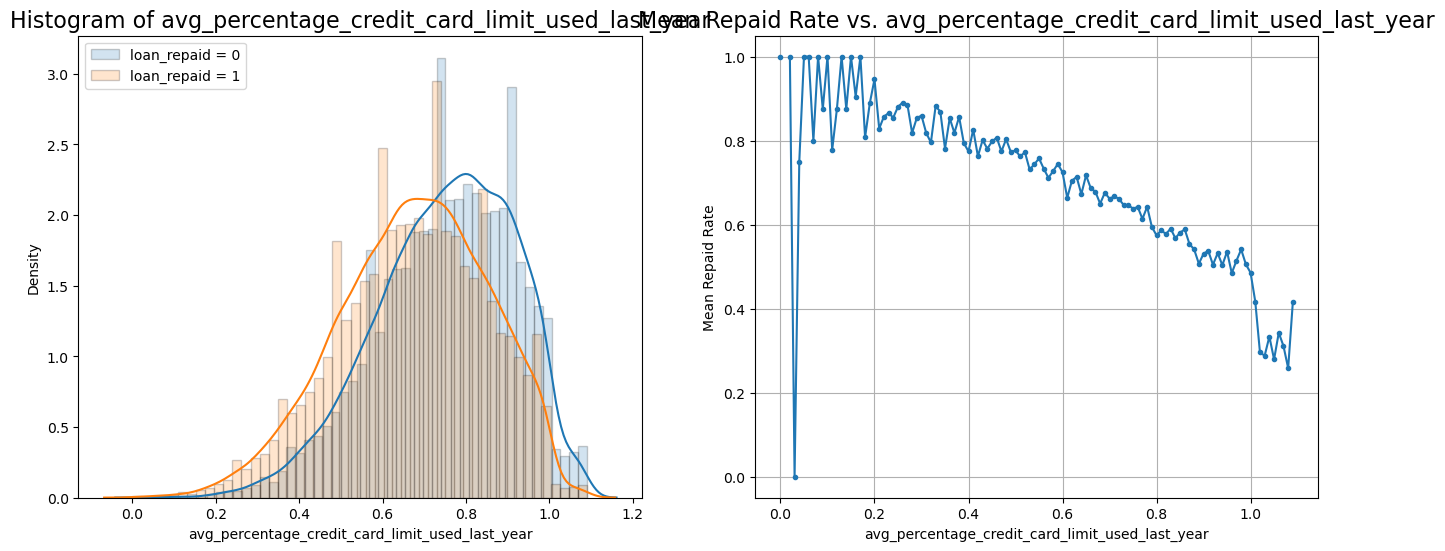

In [13]:
# Visualization of 'avg_percentage_credit_card_limit_used_last_year'
not_null = data[~data['avg_percentage_credit_card_limit_used_last_year'].isnull()]
grouped = not_null.groupby('avg_percentage_credit_card_limit_used_last_year')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(not_null[not_null['loan_repaid'] == 0]['avg_percentage_credit_card_limit_used_last_year'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(not_null[not_null['loan_repaid'] == 1]['avg_percentage_credit_card_limit_used_last_year'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of avg_percentage_credit_card_limit_used_last_year', fontsize=16)
ax[0].legend()
ax[1].plot(mean['avg_percentage_credit_card_limit_used_last_year'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. avg_percentage_credit_card_limit_used_last_year', fontsize=16)
ax[1].set_xlabel('avg_percentage_credit_card_limit_used_last_year')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

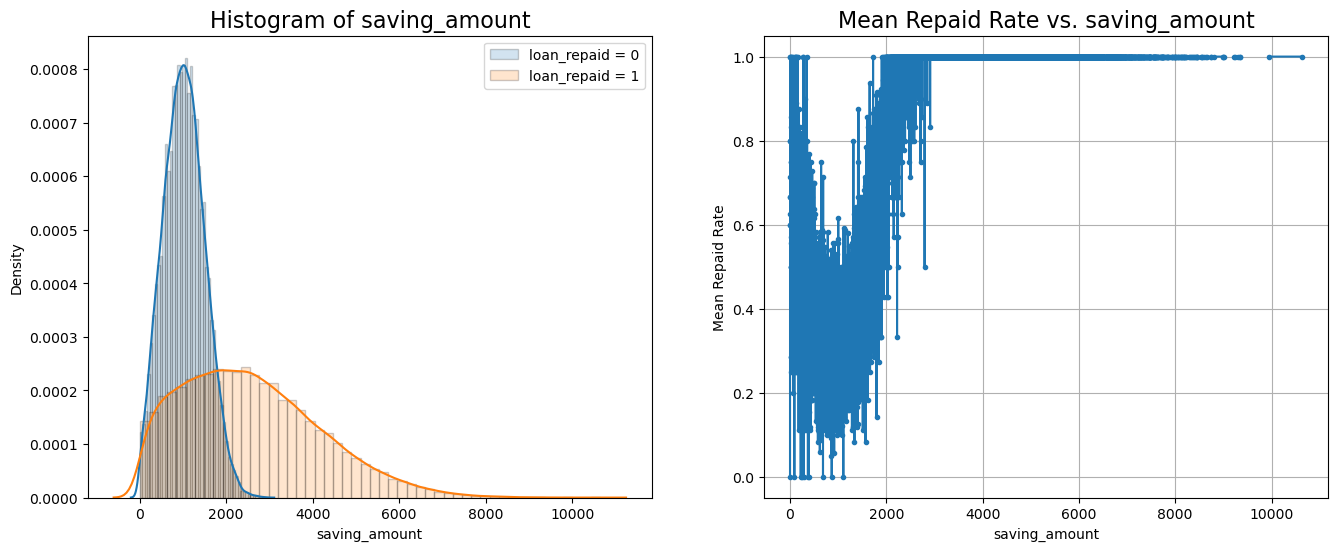

In [14]:
# Visualization of 'saving_amount'
grouped = data[['saving_amount', 'loan_repaid']].groupby('saving_amount')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['saving_amount'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['saving_amount'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of saving_amount', fontsize=16)
ax[0].legend()
ax[1].plot(mean['saving_amount'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. saving_amount', fontsize=16)
ax[1].set_xlabel('saving_amount')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

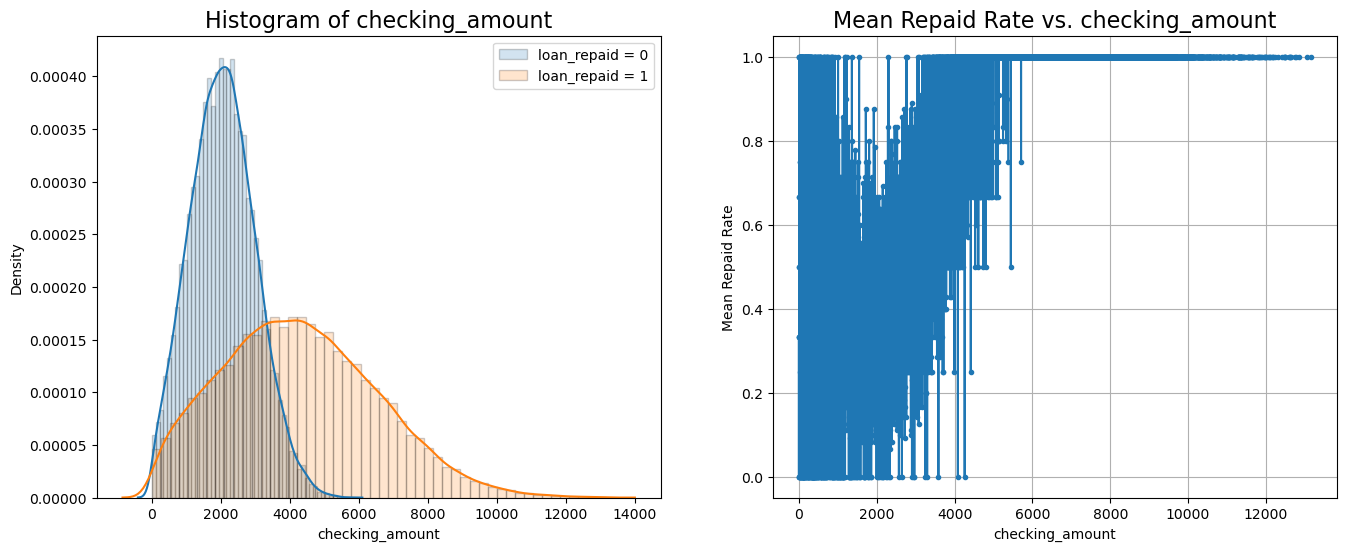

In [15]:
# Visualization of 'checking_amount'
grouped = data[['checking_amount', 'loan_repaid']].groupby('checking_amount')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['checking_amount'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['checking_amount'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of checking_amount', fontsize=16)
ax[0].legend()
ax[1].plot(mean['checking_amount'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. checking_amount', fontsize=16)
ax[1].set_xlabel('checking_amount')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

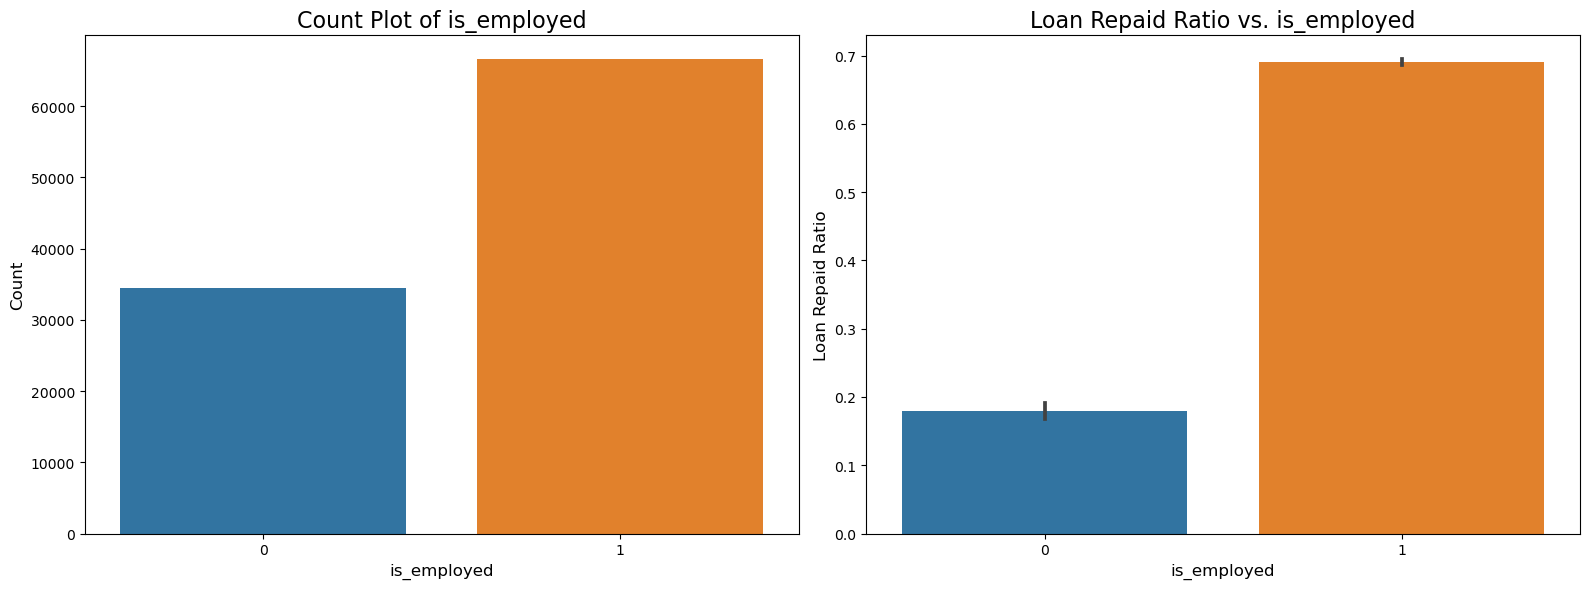

In [16]:
# visualization of 'is_employed'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_employed', data=data, ax=ax[0])
ax[0].set_xlabel('is_employed', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_employed', fontsize=16)

sns.barplot(x='is_employed', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('is_employed', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_employed', fontsize=16)
plt.tight_layout()
plt.show()

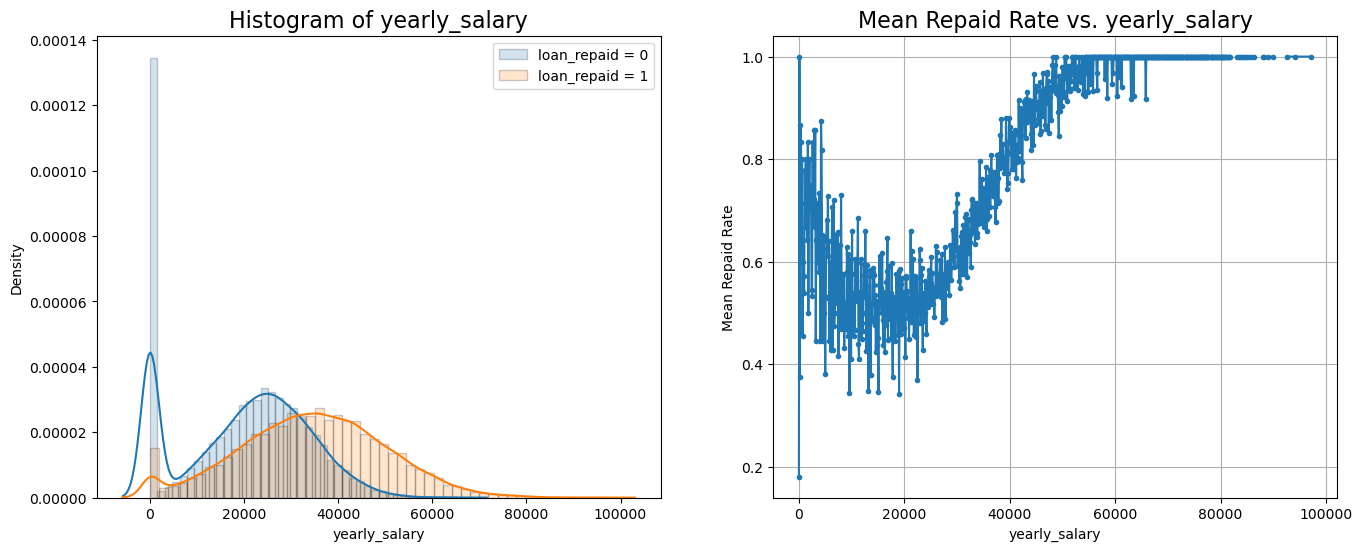

In [17]:
# Visualization of 'yearly_salary'
grouped = data[['yearly_salary', 'loan_repaid']].groupby('yearly_salary')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['yearly_salary'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['yearly_salary'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of yearly_salary', fontsize=16)
ax[0].legend()
ax[1].plot(mean['yearly_salary'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. yearly_salary', fontsize=16)
ax[1].set_xlabel('yearly_salary')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

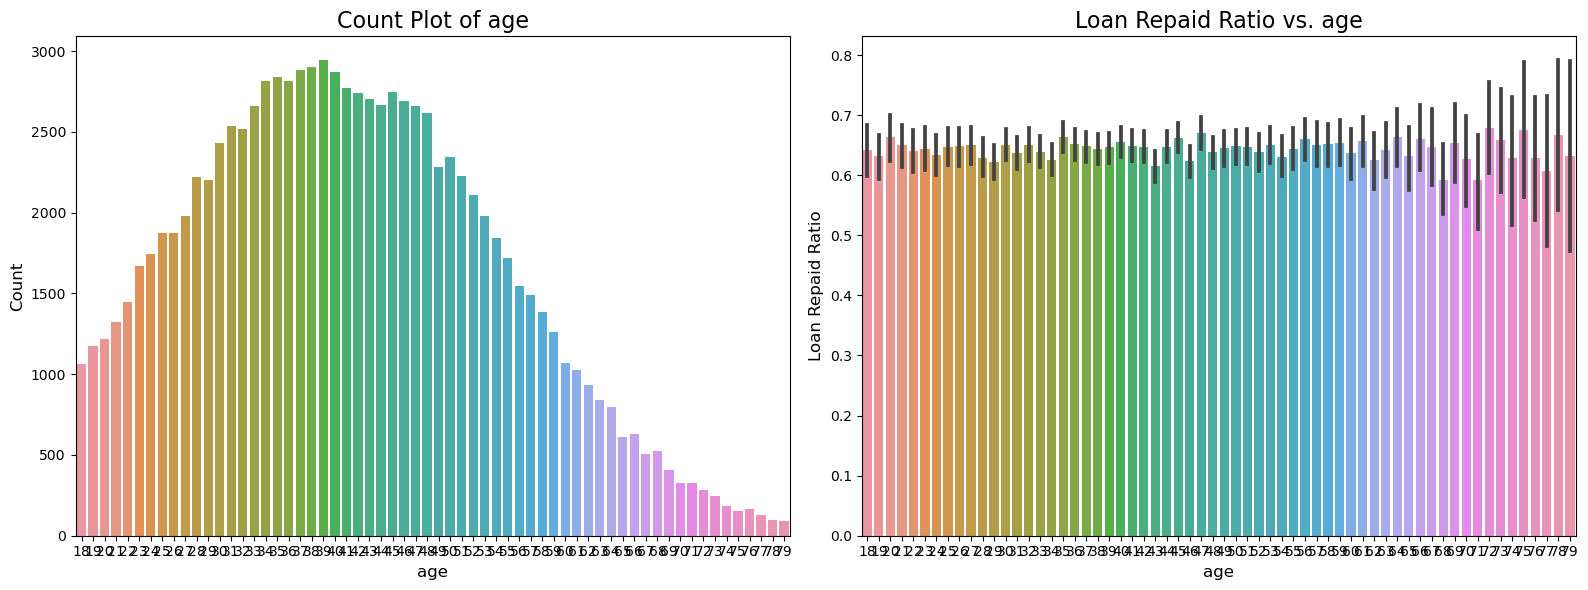

In [18]:
# visualization of 'age'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='age', data=data, ax=ax[0])
ax[0].set_xlabel('age', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of age', fontsize=16)

sns.barplot(x='age', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('age', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. age', fontsize=16)
plt.tight_layout()
plt.show()

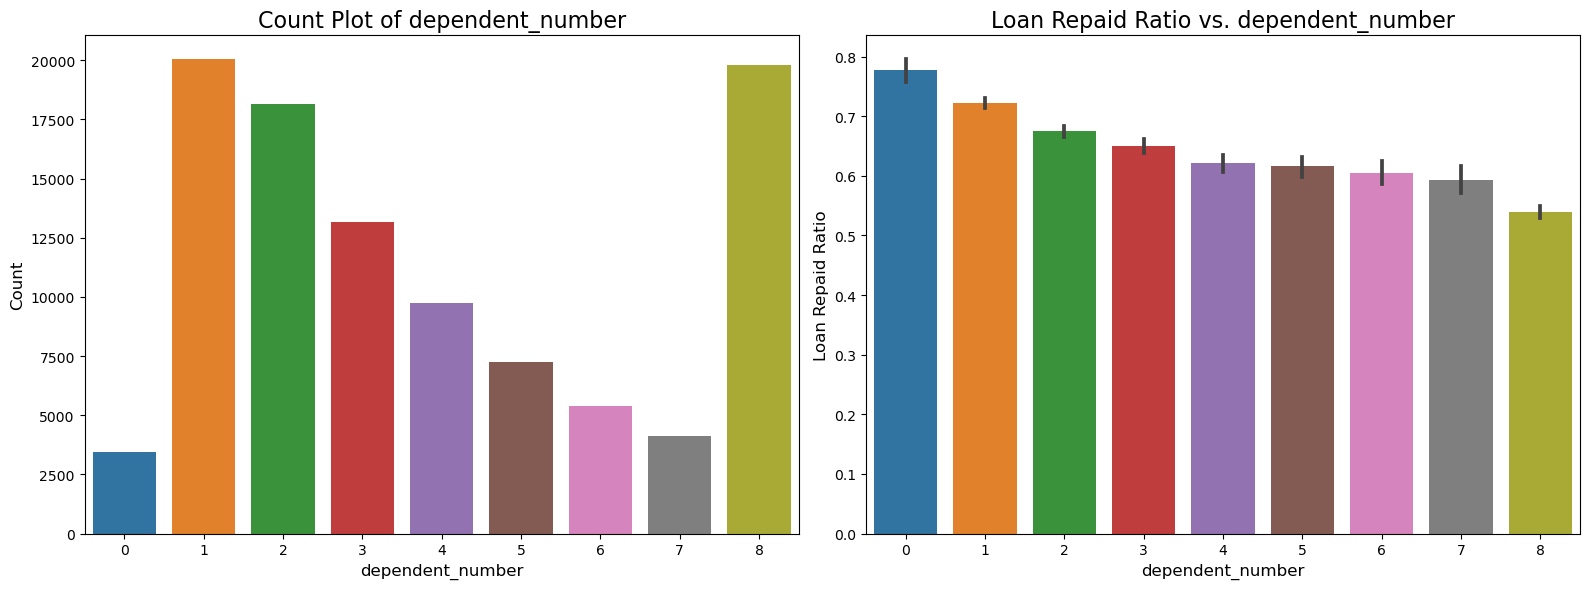

In [19]:
# visualization of 'dependent_number'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dependent_number', data=data, ax=ax[0])
ax[0].set_xlabel('dependent_number', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dependent_number', fontsize=16)

sns.barplot(x='dependent_number', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('dependent_number', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. dependent_number', fontsize=16)
plt.tight_layout()
plt.show()

### Data Cleaning

In [20]:
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [21]:
data.shape

(101100, 16)

In [22]:
# encoding 'loan_purpose'
encoder = LabelEncoder()
data['loan_purpose'] = encoder.fit_transform(data['loan_purpose'])

In [23]:
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,3,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,3,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,4,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,4,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,0,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   loan_id                                          101100 non-null  int64         
 1   loan_purpose                                     101100 non-null  int32         
 2   date                                             101100 non-null  datetime64[ns]
 3   loan_granted                                     101100 non-null  int64         
 4   loan_repaid                                      47654 non-null   float64       
 5   is_first_loan                                    101100 non-null  int64         
 6   fully_repaid_previous_loans                      46153 non-null   float64       
 7   currently_repaying_other_loans                   46153 non-null   float64       
 8   total_credit_card_limit 

In [25]:
# check missing values
missing = data.isnull().sum()
missing[missing > 0]

loan_repaid                                        53446
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
avg_percentage_credit_card_limit_used_last_year     6972
dtype: int64

##### Dealing previous loan history
There is some redundacy between 'is_first_loan', 'fully_repaid_previous_loans' and 'currently_repaying_other_loans' features. If 'is_first_loan'==1, then 'fully_repaid_previous_loans' and 'currently_repaying_other_loans' are both NaN for sure.

Since I am going to use tree model, which is good at dealing with 'categorical feature', so I will treat the tree features like below:

Set 'NaN' in 'fully_repaid_previous_loans' and 'currently_repaying_other_loans' as -1, which indicates the brower is asking for loan the first time and discard 'is_first_loan' feature, since its information has already been included in '-1' in 'fully_repaid_previous_loans' and 'currently_repaying_other_loans'.

In other words, I treat 'fully_repaid_previous_loans' and 'currently_repaying_other_loans' as categorical feature, and just use Ordinary Ordinal Encoding other than more-often used One-Hot-Encoding. Because tree models look for cutoff in numeric feature other than calculating the distance, and there is only 3 unique values in the feature (-1,0,1), which is very easy to find cutoff to distinguish each category.

In [26]:
data.fillna({'fully_repaid_previous_loans':-1,'currently_repaying_other_loans':-1},inplace=True)
del data['is_first_loan']

data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,3,2012-03-15,0,NaN,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7
1,496811,3,2012-01-17,0,NaN,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5
2,929493,4,2012-02-09,0,NaN,-1.0,-1.0,0,NaN,660,3232,1,26500,60,4
3,580653,4,2012-06-27,1,1.0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,0,2012-05-21,1,0.0,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 15 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   loan_id                                          101100 non-null  int64         
 1   loan_purpose                                     101100 non-null  int32         
 2   date                                             101100 non-null  datetime64[ns]
 3   loan_granted                                     101100 non-null  int64         
 4   loan_repaid                                      47654 non-null   float64       
 5   fully_repaid_previous_loans                      101100 non-null  float64       
 6   currently_repaying_other_loans                   101100 non-null  float64       
 7   total_credit_card_limit                          101100 non-null  int64         
 8   avg_percentage_credit_ca

<AxesSubplot:xlabel='avg_percentage_credit_card_limit_used_last_year', ylabel='Count'>

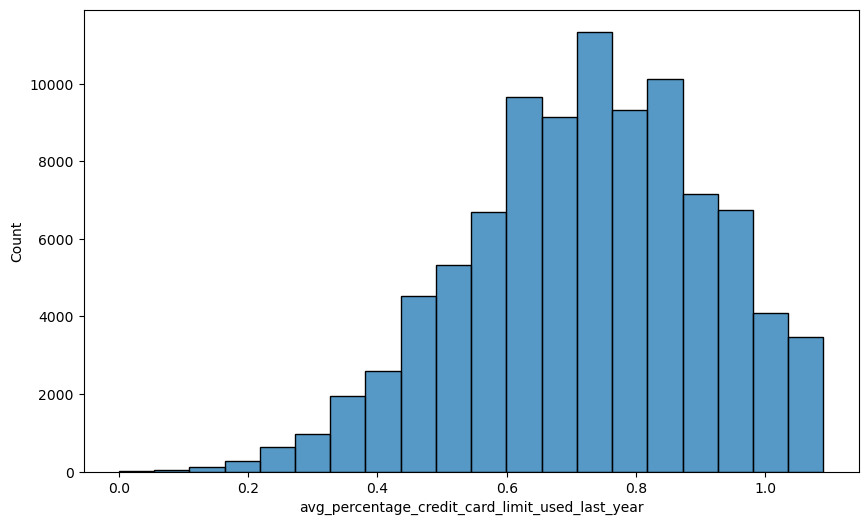

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(x='avg_percentage_credit_card_limit_used_last_year', data=data, bins=20)

In [29]:
data['avg_percentage_credit_card_limit_used_last_year'].describe()

count    94128.000000
mean         0.724140
std          0.186483
min          0.000000
25%          0.600000
50%          0.730000
75%          0.860000
max          1.090000
Name: avg_percentage_credit_card_limit_used_last_year, dtype: float64

In [30]:
# fill missing values with median
median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data = data.fillna({'avg_percentage_credit_card_limit_used_last_year': median})

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 15 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   loan_id                                          101100 non-null  int64         
 1   loan_purpose                                     101100 non-null  int32         
 2   date                                             101100 non-null  datetime64[ns]
 3   loan_granted                                     101100 non-null  int64         
 4   loan_repaid                                      47654 non-null   float64       
 5   fully_repaid_previous_loans                      101100 non-null  float64       
 6   currently_repaying_other_loans                   101100 non-null  float64       
 7   total_credit_card_limit                          101100 non-null  int64         
 8   avg_percentage_credit_ca

In [32]:
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,3,2012-03-15,0,NaN,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7
1,496811,3,2012-01-17,0,NaN,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5
2,929493,4,2012-02-09,0,NaN,-1.0,-1.0,0,0.73,660,3232,1,26500,60,4
3,580653,4,2012-06-27,1,1.0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,0,2012-05-21,1,0.0,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4


In [33]:
# drop useless features
data = data.drop(labels=['loan_id', 'date'], axis=1, inplace=False)
data.head()

,loan_purpose,loan_granted,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,3,0,NaN,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7
1,3,0,NaN,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5
2,4,0,NaN,-1.0,-1.0,0,0.73,660,3232,1,26500,60,4
3,4,1,1.0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,0,1,0.0,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4


##### Generate Target

In [34]:
def calc_profit_and_should_grant(row):
    """
    generate 'profit' and 'should_grant' target column according to rule:
    1. if not granted, profit=0, should_grant=0
    2. if granted and repaid, profit=1, should_grant=1
    3. if granted and not repaid, profit=-1, should_grant=0
    """
    loan_granted = row['loan_granted']
    loan_repaid = row['loan_repaid']

    profit = 0
    should_grant = 0

    if loan_granted == 0:
        profit = 0
        should_grant = 0
    else: # loan_granted == 1
        assert pd.notnull(loan_repaid)
        profit = 1 if loan_repaid == 1 else -1
        should_grant = 1 if loan_repaid == 1 else 0

    return pd.Series({'profit':profit,'should_grant':should_grant})

In [35]:
profits = data.apply(calc_profit_and_should_grant,axis=1)

In [36]:
data = data.join(profits) # merget together

In [37]:
data.head()

,loan_purpose,loan_granted,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,profit,should_grant
0,3,0,NaN,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7,0,0
1,3,0,NaN,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5,0,0
2,4,0,NaN,-1.0,-1.0,0,0.73,660,3232,1,26500,60,4,0,0
3,4,1,1.0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,1,1
4,0,1,0.0,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,-1,0


In [38]:
# drop useless features
data = data.drop(labels=['loan_granted'], axis=1, inplace=False)
data.head()

,loan_purpose,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,profit,should_grant
0,3,NaN,-1.0,-1.0,8600,0.79,1491,6285,1,45200,42,7,0,0
1,3,NaN,-1.0,-1.0,5300,0.52,141,5793,0,0,42,5,0,0
2,4,NaN,-1.0,-1.0,0,0.73,660,3232,1,26500,60,4,0,0
3,4,1.0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,1,1
4,0,0.0,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,-1,0


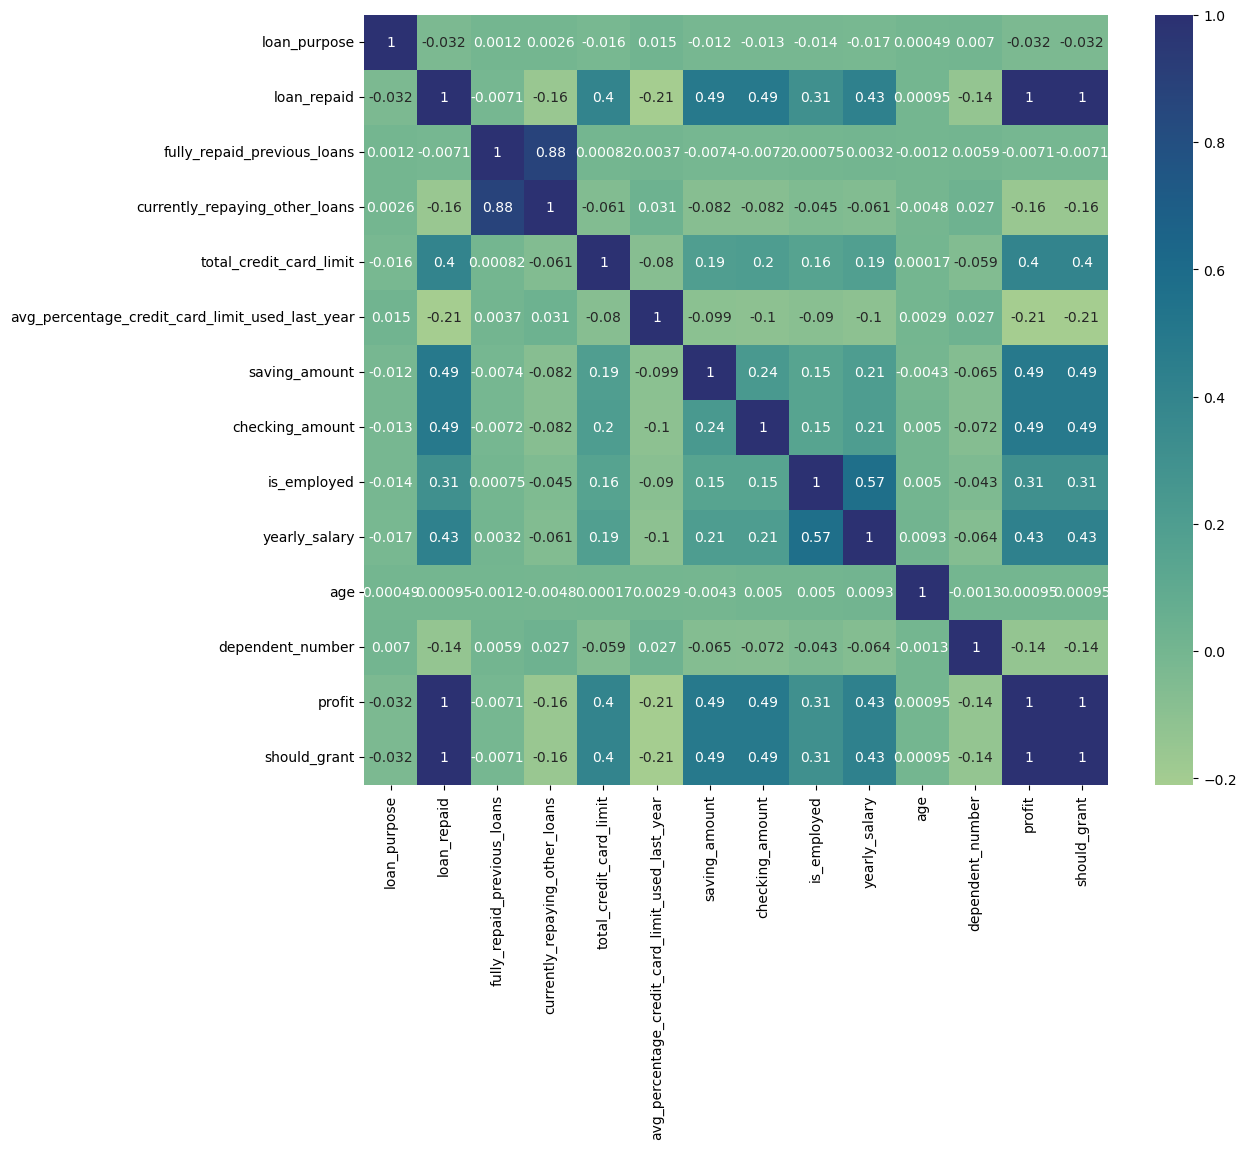

In [39]:
# feature correlation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.dropna(axis=0).corr(), cmap='crest', annot=True, ax=ax)
plt.show()

In [40]:
# drop high correlation features
data = data.drop(labels=['currently_repaying_other_loans'], axis=1, inplace=False)
data.head()

,loan_purpose,loan_repaid,fully_repaid_previous_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,profit,should_grant
0,3,NaN,-1.0,8600,0.79,1491,6285,1,45200,42,7,0,0
1,3,NaN,-1.0,5300,0.52,141,5793,0,0,42,5,0,0
2,4,NaN,-1.0,0,0.73,660,3232,1,26500,60,4,0,0
3,4,1.0,1.0,5400,0.52,3345,2764,1,15800,58,4,1,1
4,0,0.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,-1,0


### Machine Learning Model

In [41]:
y = data.loc[:,'should_grant']

feature_names = ['loan_purpose', 'fully_repaid_previous_loans', 'total_credit_card_limit', 'avg_percentage_credit_card_limit_used_last_year',
                 'saving_amount', 'checking_amount', 'is_employed', 'yearly_salary', 'age', 'dependent_number']
X = data.loc[:,feature_names]

In [42]:
y.value_counts(normalize=True)

0    0.696281
1    0.303719
Name: should_grant, dtype: float64

Positive class 'loan_repaid=1' consists of about 35% of all examples. There is some imbalance in the dataset.

- We should use AUC other than accuracy when learning the model.
- We need to choose a better 'probability cutoff' instead of using the default 0.5.

In [43]:
# split as training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

# split the training data as training and test
Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)

In [44]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
valid_matrix = xgb.DMatrix(Xvalid,yvalid)
test_matrix = xgb.DMatrix(Xtest,ytest)

In [45]:
def train(params):
    params['silent'] = 1
    params['objective'] = 'binary:logistic'  # output probabilities
    params['eval_metric'] = 'auc'

    num_rounds = params['num_rounds']
    early_stopping_rounds = params['early_stop_rounds']

    # early stop will check on the last dataset
    watchlist = [(train_matrix, 'train'), (valid_matrix, 'validate')]
    bst = xgb.train(params, train_matrix, num_rounds, watchlist, early_stopping_rounds=early_stopping_rounds)

    print('parameters: {}'.format(params))
    print('best {}: {:.2f}'.format(params['eval_metric'], bst.best_score))
    print('best #trees: %d' % (bst.best_ntree_limit))

    return bst

In [46]:
# ------------- prepare parameters
params = {}
params['num_rounds'] = 300
params['early_stop_rounds'] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

# ------------- train with xgboost
bst = train(params)

[10:19:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stop_rounds", "num_rounds", "silent" } are not used.

[0]	train-auc:0.88898	validate-auc:0.88541
[1]	train-auc:0.89198	validate-auc:0.88683
[2]	train-auc:0.89401	validate-auc:0.88794
[3]	train-auc:0.89473	validate-auc:0.88843
[4]	train-auc:0.89544	validate-auc:0.88899
[5]	train-auc:0.89652	validate-auc:0.88894
[6]	train-auc:0.89653	validate-auc:0.89061
[7]	train-auc:0.89681	validate-auc:0.89069
[8]	train-auc:0.89774	validate-auc:0.89148
[9]	train-auc:0.89783	validate-auc:0.89152
[10]	train-auc:0.89821	validate-auc:0.89154
[11]	train-auc:0.89889	validate-auc:0.89150
[12]	train-auc:0.89907	validate-auc:0.89193
[13]	train-auc:0.89938	validate-auc:0.89210
[14]	train-auc:0.89959	validate-auc:0.89220
[15]	train-auc:0.89979	validate-auc:0.89233
[16]	train-auc:0.90033	validate-auc:0.89254
[17]	train-auc:0.90060	validate

[180]	train-auc:0.94410	validate-auc:0.89487
[181]	train-auc:0.94419	validate-auc:0.89491
[182]	train-auc:0.94442	validate-auc:0.89495
[183]	train-auc:0.94449	validate-auc:0.89493
[184]	train-auc:0.94473	validate-auc:0.89490
[185]	train-auc:0.94483	validate-auc:0.89483
[186]	train-auc:0.94517	validate-auc:0.89486
[187]	train-auc:0.94525	validate-auc:0.89485
[188]	train-auc:0.94540	validate-auc:0.89491
[189]	train-auc:0.94551	validate-auc:0.89488
[190]	train-auc:0.94565	validate-auc:0.89488
[191]	train-auc:0.94578	validate-auc:0.89484
[192]	train-auc:0.94607	validate-auc:0.89479
parameters: {'num_rounds': 300, 'early_stop_rounds': 30, 'max_depth': 6, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'silent': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
best auc: 0.90
best #trees: 164


In [47]:
n_trees = bst.best_ntree_limit
n_trees

164

##### Choose best probablity cutoff

In [48]:
yvalid_true = valid_matrix.get_label()
yvalid_pred_probas = bst.predict(valid_matrix, ntree_limit=bst.best_ntree_limit)

fpr,tpr,thresholds = roc_curve(yvalid_true,yvalid_pred_probas)
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

In [49]:
def calc_profits(repaids,probas,threshold):
    total_profit = 0
    for (repaid,proba) in zip(repaids,probas):
        if proba > threshold:
            # it is possible for repaid=NaN
            # which means, my model grant loan to a borrower whose application was rejected under old model
            # the question doesn't clarify how to calculate profit for such case.
            # however, since most 'rejected borrowers' were considered unlikely to repay by old model
            # so I also think such people are very unlikely to repay even were granted
            # so their profit are also -1, the same as 'granted but unable to repay'
            total_profit += (1 if repaid == 1 else -1)
    return total_profit

In [50]:
# all examples in validation sets
loan_valid = data.loc[yvalid.index,:]

# calculate profits under each candidate cutoff
valid_profits = [calc_profits(loan_valid.loan_repaid,yvalid_pred_probas,threshold) for threshold in roc.Thresholds]

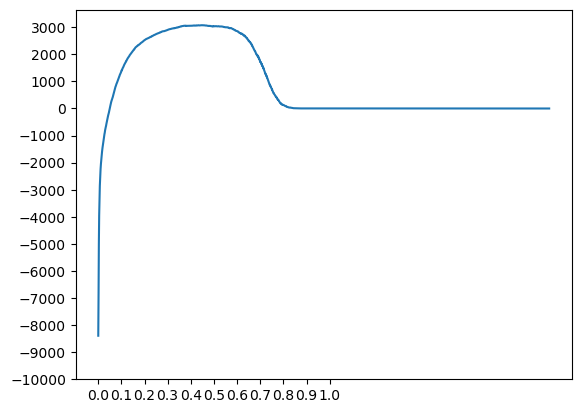

In [51]:
plt.plot(roc.Thresholds,valid_profits)
plt.yticks(range(-10000,4000,1000))
_ = plt.xticks(np.linspace(0,1,11))
plt.rc('figure',figsize=(5,5))

In [52]:
valid_threshold_profits = pd.DataFrame({'threshold':roc.Thresholds,'profit':valid_profits})
temp = valid_threshold_profits.loc[valid_threshold_profits.profit.argmax()   ,:]
temp

threshold       0.448592
profit       3076.000000
Name: 3229, dtype: float64

In [53]:
proba_threshold = temp['threshold']
proba_threshold

0.44859206676483154

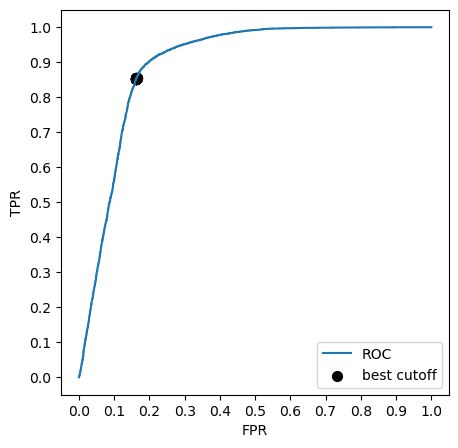

In [54]:
# plot ROC
plt.plot(roc.FPR,roc.TPR,label='ROC')
plt.xlabel("FPR")
plt.ylabel('TPR')

ticks = np.linspace(0,1,11)
plt.yticks(ticks)
plt.xticks(ticks)

# plot best thresholds
best_cutoffs = roc.loc[ (roc.Thresholds > 0.44) & (roc.Thresholds < 0.45),:]
plt.scatter(best_cutoffs.FPR,best_cutoffs.TPR,c='k',s=50,label='best cutoff')

plt.rc('figure',figsize=(10,5))
plt.legend(loc='best')

##### Re-train the model with all training data

In [55]:
# combine training set and validation set together
Xalltrain = pd.concat([Xtrain,Xvalid],axis=0)
yalltrain = pd.concat([ytrain,yvalid],axis=0)
alltrain_matrix = xgb.DMatrix(Xalltrain,yalltrain)

In [56]:
# check the parameters
params

{'num_rounds': 300,
 'early_stop_rounds': 30,
 'max_depth': 6,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'silent': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [57]:
# best number of trees
n_trees

164

In [58]:
watchlist = [(alltrain_matrix, 'train')]
all_bst = xgb.train(params, alltrain_matrix, n_trees,watchlist)

[10:20:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stop_rounds", "num_rounds", "silent" } are not used.

[0]	train-auc:0.88828
[1]	train-auc:0.89115
[2]	train-auc:0.89246
[3]	train-auc:0.89326
[4]	train-auc:0.89343
[5]	train-auc:0.89387
[6]	train-auc:0.89410
[7]	train-auc:0.89545
[8]	train-auc:0.89606
[9]	train-auc:0.89630
[10]	train-auc:0.89672
[11]	train-auc:0.89735
[12]	train-auc:0.89759
[13]	train-auc:0.89802
[14]	train-auc:0.89826
[15]	train-auc:0.89843
[16]	train-auc:0.89850
[17]	train-auc:0.89883
[18]	train-auc:0.89942
[19]	train-auc:0.89951
[20]	train-auc:0.89963
[21]	train-auc:0.89986
[22]	train-auc:0.90019
[23]	train-auc:0.90037
[24]	train-auc:0.90056
[25]	train-auc:0.90096
[26]	train-auc:0.90108
[27]	train-auc:0.90128
[28]	train-auc:0.90134
[29]	train-auc:0.90147
[30]	train-auc:0.90166
[31]	train-auc:0.90196
[32]	train-auc:0.90198
[33]	train-auc:0.902

##### Test

In [59]:
ytest_pred_probas = all_bst.predict(test_matrix, ntree_limit=n_trees)
ytest_pred = (ytest_pred_probas > proba_threshold).astype(int)

In [60]:
print('test accuracy: ',accuracy_score(ytest,ytest_pred))

test accuracy:  0.8399934058687768


In [61]:
print(classification_report(ytest,ytest_pred))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     20939
           1       0.70      0.85      0.77      9391

    accuracy                           0.84     30330
   macro avg       0.81      0.84      0.82     30330
weighted avg       0.86      0.84      0.84     30330



In [62]:
# profit under old model
loan_test = data.loc[ytest.index,:]
old_profit = loan_test.profit.sum()
old_profit

4294

In [63]:
# profit under new model
new_profit = calc_profits(loan_test.loan_repaid,ytest_pred_probas,proba_threshold)
new_profit

4538

### Q1, Q2:
Build a model which is better than the bank model. For simplicity, assume that:
If you grant the loan and the it doesn't get repaid, you lose 1
If you grant the loan and the it does get repaid, you gain 1
If you don't grant the loan, you gain 0

Using the rules above, compare bank profitability vs your model profitability

From the result above, the old model yields a profit as 4294, while the new model can yield a profit 4538, which improved about 5.7%.

### Q3:
Describe the impact of the most important variables on the prediction. Also, focus on the variable "is_employed", which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why

##### Feature importance

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='F score', ylabel='Features'>

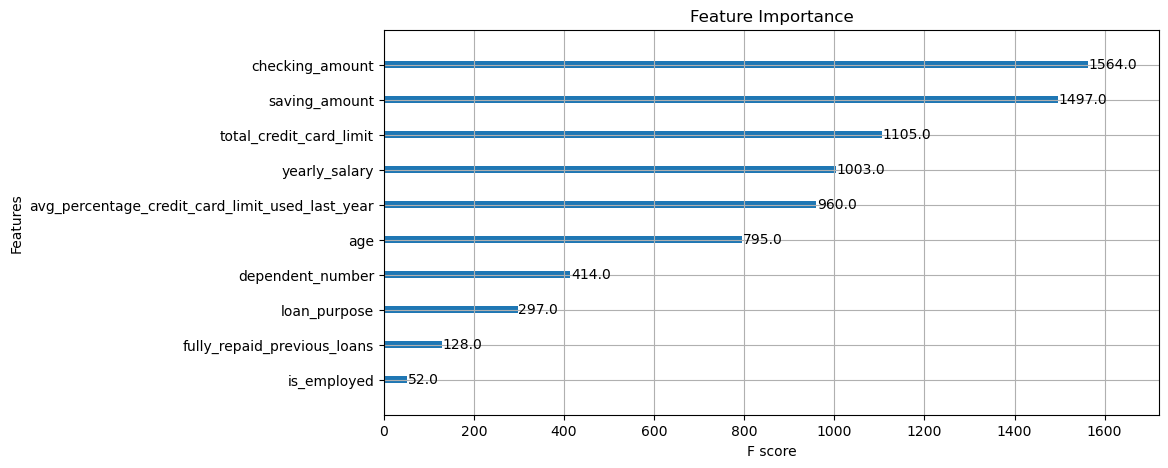

In [64]:
xgb.plot_importance(all_bst,title='Feature Importance')

According to the plot above, the most important features are 'checking_amount' and 'saving_account'. This makes perfect sense. Money in the accounts, meaure a person's ability to control his/her financial situation. More money in the saving account, more likely the borrower can repay.

The feature 'is_employed' is the least important. Even though a person employed, if his/her salary is low, he/she would not be able to repay the loan. Hence, this feature could be hard to distingusih a real loan repay ability of a person.

### Q4: Are there any other variables, not in the data provided, that you'd have liked to include in the model?

- Marriage status.
    - Because even a borrow cannot repay, if he/she is married, his/her spouse can help to repay.
- Housing status, has his/her own house, or rent appartments? if renting, how much is monthly rent?
    - Because even the borrower cannot repay, if he/she has house, the house can be sold to repay the debt
- Educational level
    - Normally a person who received higher education, has stronger capability to earn money to repay, and has higher moral standard to repay.